In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
import seaborn as sns

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util
from bespoke.blaze_preapprovals import blaze_uw as blaze_uw

%load_ext autoreload
%autoreload 2

# ~ Part 1: Create UW data ~
This part is to read multiple queries to pull all the relevant data needed to perform underwriting.

## Gross Margin

In [3]:
blaze_gm_data = pd.read_sql_query(blaze_uw.create_blaze_gm_query('CA'),engine)
blaze_gm_data['year_month'] = pd.to_datetime(blaze_gm_data['year_month'])

In [4]:
# Check N of shops to underwrite
blaze_gm_data[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,194
2021-09-30,205
2021-10-31,224
2021-11-30,225
2021-12-31,238
2022-01-31,241
2022-02-28,243
2022-03-31,251
2022-04-30,248


In [5]:
# only underwrite those with more than 6 months of history data
blaze_gm_data_long = blaze_gm_data[blaze_gm_data['month_available'] >= 6]
blaze_gm_data_long[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,182
2021-09-30,192
2021-10-31,203
2021-11-30,215
2021-12-31,228
2022-01-31,238
2022-02-28,239
2022-03-31,245
2022-04-30,245


## Monthly GMV change

In [ ]:
gmv_change_variance_point_mapping

In [8]:
#you can also query like this0
blaze_ca_gmv_change_data = pd.read_sql_query(blaze_uw.create_blaze_gmv_change_query('CA'),engine)
blaze_ca_gmv_change_data['year_month'] = pd.to_datetime(blaze_ca_gmv_change_data['year_month'])

<AxesSubplot:>

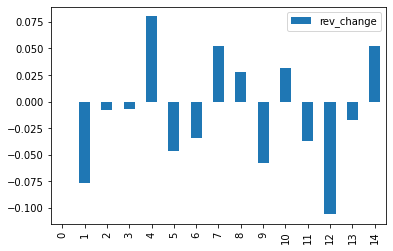

In [9]:
blaze_ca_gmv_change_data[['rev_change']].plot(kind = 'bar')

In [10]:
blaze_ca_gmv_change_data

,year_month,rev_pre_tax_post_discount,count_shop,lag_rev_pre_tax_post_discount,lag_count_shop,rev_per_shop,lag_rev_per_shop,rev_change
0,2021-08-31,59940637.30,195,NaN,NaN,307387.883590,NaN,NaN
1,2021-09-30,58766252.04,207,59940637.30,195.0,283894.937391,307387.883590,-0.076428
2,2021-10-31,63377982.71,225,58766252.04,207.0,281679.923156,283894.937391,-0.007802
3,2021-11-30,63792764.24,228,63377982.71,225.0,279792.825614,281679.923156,-0.006699
4,2021-12-31,72521153.59,240,63792764.24,228.0,302171.473292,279792.825614,0.079983
5,2022-01-31,70290344.08,244,72521153.59,240.0,288075.180656,302171.473292,-0.046650
6,2022-02-28,68129772.35,245,70290344.08,244.0,278080.703469,288075.180656,-0.034694
7,2022-03-31,73745755.49,252,68129772.35,245.0,292641.886865,278080.703469,0.052363
8,2022-04-30,74882286.50,249,73745755.49,252.0,300732.074297,292641.886865,0.027645
9,2022-05-31,71977419.98,254,74882286.50,249.0,283375.669213,300732.074297,-0.057714


In [11]:
rev_change_bm_with_weight = blaze_ca_gmv_change_data[['year_month','rev_change']]
rev_change_bm_with_weight['weight'] = [numpy.nan,numpy.nan,0.04,0.12,0.2,0.28,0.36,0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]
rev_change_bm_with_weight.columns = ['year_month','rev_change_bm','rev_change_weight']
rev_change_bm_with_weight = rev_change_bm_with_weight.reset_index(drop = True)
rev_change_bm_with_weight

,year_month,rev_change_bm,rev_change_weight
0,2021-08-31,NaN,NaN
1,2021-09-30,-0.076428,NaN
2,2021-10-31,-0.007802,0.04
3,2021-11-30,-0.006699,0.12
4,2021-12-31,0.079983,0.20
5,2022-01-31,-0.046650,0.28
6,2022-02-28,-0.034694,0.36
7,2022-03-31,0.052363,0.44
8,2022-04-30,0.027645,0.52
9,2022-05-31,-0.057714,0.60


In [14]:
# calculate each location's gmv change & gmv change vs state
blaze_gm_data_long_with_rev  = pd.merge(blaze_gm_data_long,rev_change_bm_with_weight,on=['year_month'], how='inner')
blaze_gm_data_long_with_rev['rev_change_var'] = blaze_gm_data_long_with_rev['rev_change'] - blaze_gm_data_long_with_rev['rev_change_bm']
blaze_gm_data_long_with_rev['rev_change_points'] = [blaze_uw.gmv_change_variance_point_mapping(n) for n in blaze_gm_data_long_with_rev['rev_change_var']]
blaze_gm_data_long_with_rev['rev_change_total'] = blaze_gm_data_long_with_rev['rev_change_points'] * blaze_gm_data_long_with_rev['rev_change_weight']


In [15]:
# #example
blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['shopid'] == '5c8844b3e0faca07c1ec05ec']

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total
81,2021-08-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,1391798.44,NaN,830472.07,561326.37,0.403310,15,830472.07,0.403310,0.403310,0.403310,NaN,NaN,NaN,NaN,NaN,NaN
267,2021-09-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,1074072.70,1391798.44,611701.37,462371.33,0.430484,15,1442173.44,0.416897,0.416897,0.416897,-0.228284,-0.076428,NaN,-0.151857,-5.0,NaN
466,2021-10-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,874744.85,1074072.70,496259.85,378485.00,0.432680,15,1938433.29,0.422158,0.422158,0.422158,-0.185581,-0.007802,0.04,-0.177779,-5.0,-0.2
678,2021-11-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,799791.11,874744.85,435482.17,364308.94,0.455505,15,1543443.39,0.439557,0.430495,0.430495,-0.085686,-0.006699,0.12,-0.078987,-2.5,-0.3
900,2021-12-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,815170.38,799791.11,423727.00,391443.38,0.480198,15,1355469.02,0.456128,0.440436,0.440436,0.019229,0.079983,0.20,-0.060754,-2.5,-0.5
1133,2022-01-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,737584.96,815170.38,385753.60,351831.36,0.477005,15,1244962.77,0.470903,0.446530,0.446530,-0.095177,-0.046650,0.28,-0.048527,0.0,0.0
1368,2022-02-28,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,657139.60,737584.96,382555.91,274583.69,0.417847,15,1192036.51,0.458350,0.448953,0.442433,-0.109066,-0.034694,0.36,-0.074372,-2.5,-0.9
1608,2022-03-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,637828.04,657139.60,350448.31,287379.73,0.450560,15,1118757.82,0.448470,0.452299,0.443449,-0.029387,0.052363,0.44,-0.081750,-2.5,-1.1
1854,2022-04-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,760663.72,637828.04,423784.99,336878.73,0.442875,15,1156789.21,0.437094,0.453998,0.443385,0.192584,0.027645,0.52,0.164939,10.0,5.2
2101,2022-05-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,720346.24,760663.72,369500.65,350845.59,0.487051,15,1143733.95,0.460162,0.459256,0.447752,-0.053003,-0.057714,0.60,0.004711,5.0,3.0


## Inventory

In [16]:
#need to define the uw date first
uw_date = '2022-10-31'

In [17]:
inventory_date_list = pd.read_sql_query(blaze_uw.create_blaze_inventory_date_query('CA',uw_date),engine)

In [18]:
blaze_inv_data_all = pd.read_sql_query(blaze_uw.create_blaze_inventory_query('CA',tuple([str(x) for x in inventory_date_list['date']])),engine)
blaze_inv_data_all['year_month'] = pd.to_datetime(blaze_inv_data_all['year_month'])

In [19]:
#calculate fresh, stale, fresh + stale inventory
fresh_inv = blaze_inv_data_all[blaze_inv_data_all['inventory_group'] == 'fresh'][['year_month','shopid','companyid','inventory']]
stale_inv = blaze_inv_data_all[blaze_inv_data_all['inventory_group'] == 'stale'][['year_month','shopid','companyid','inventory']]
fresh_and_stale_inv = fresh_inv.merge(stale_inv, on = ['shopid','companyid','year_month'],how = 'outer')
fresh_and_stale_inv = fresh_and_stale_inv.fillna(0)
fresh_and_stale_inv.columns = ['year_month','shopid','companyid','inventory_fresh','inventory_stale']
fresh_and_stale_inv['inventory_fresh_and_stale'] = fresh_and_stale_inv['inventory_fresh']  + fresh_and_stale_inv['inventory_stale']

In [20]:
fresh_and_stale_inv

,year_month,shopid,companyid,inventory_fresh,inventory_stale,inventory_fresh_and_stale
0,2022-10-31,5b256a8eff7e6b08094adb42,5b1dbdf3cf43c1080b198e70,178851.541,23439.518000,202291.059000
1,2022-10-31,5cb7afe2829a5f08344551eb,5ba96aac00635e08245eb7b0,72037.491,10651.244000,82688.735000
2,2022-10-31,5d6fcbda977e0d084ac36050,5d6fcbda977e0d084ac36039,67786.355,28176.183000,95962.538000
3,2022-10-31,5df3a68c0c2672082b2fb810,5d45d67add8d1b07f5e77a56,10960.000,0.000000,10960.000000
4,2022-10-31,5e2dddbde0faca07d408d9ee,5e2dddbde0faca07d408d9d6,106729.976,5149.674000,111879.650000
...,...,...,...,...,...,...
316,2022-10-31,5d2629fee0faca0814971cbe,5cf87947e184f10821fc86ef,0.000,119567.000000,119567.000000
317,2022-10-31,611a90e4a5c5393655da2294,611a90e4a5c5393655da227b,0.000,5760.300000,5760.300000
318,2022-10-31,5f77c6ead2fbea08c8d15a22,5f77c6ead2fbea08c8d15a0a,0.000,22663.587914,22663.587914
319,2022-10-31,5eac4005e0faca07f879503a,5eac4005e0faca07f8795022,0.000,1163.500000,1163.500000


In [21]:
#make sure we do not lack inventory data for too many locations (usually 1 or 2 are fine)
set(blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['year_month'] == uw_date]['shopid']) - set(fresh_and_stale_inv['shopid'])



{'5bcad4618cc04c08353ffe15'}

## Inventory Turnover

In [22]:
data_joined = pd.merge(blaze_gm_data_long_with_rev,fresh_and_stale_inv,on=['year_month','shopid','companyid'], how='inner')



In [23]:
data_joined['inventory_turnover'] = data_joined['sum_cogs_3m'] / data_joined['inventory_fresh_and_stale'] * 4
data_joined['year_month'] = pd.to_datetime(data_joined['year_month'])

In [25]:
# some sanity checks
# data_joined[data_joined['year_month'] >= '2021-10-31'].groupby(['year_month'])['inventory_turnover'].describe().reset_index()
# round(data_joined['inventory_turnover'].quantile(0.95),2)

,year_month,count,mean,std,min,25%,50%,75%,max
0,2022-10-31,216.0,10.752873,6.314575,0.0696,6.47824,9.723368,13.637297,36.489353


## Vendor Churn

In [27]:
# read the VC data
blaze_vc_data = pd.read_sql_query(blaze_uw.create_blaze_vc_query('CA',uw_date),engine)

In [28]:
# join other uw data with vc
data_joined_with_vc = data_joined.merge(blaze_vc_data,on = 'shopid',how = 'left')
data_joined_with_vc = data_joined_with_vc.fillna(0)

In [ ]:
#data_joined_with_vc['total_vc'].describe()

# ~ Part 2: Start UW ~
Now that we have all the essential data for UW. We choose the date we want to perform underwriting on and start calculating the KPIs.

In [29]:
recent = data_joined_with_vc[data_joined_with_vc['year_month'] == '2022-10-31']
recent = recent.reset_index(drop = True)

In [31]:
# check final # of locations to UW
recent[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2022-10-31,216


## 1. gm % score

In [32]:
gm_threshold = [[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7]]

In [33]:
gm_score_data = recent.apply(lambda row: blaze_uw.get_gm_perc_scores(gm_threshold,row['avg_margin_3m'],row['avg_margin_6m'],row['avg_margin_all']),axis = 1)
recent_with_gm = pd.concat([recent, pd.DataFrame([list(y) for y in gm_score_data.values], columns = ['gm_3m_score', 'gm_6m_score','gm_all_score'])],axis=1)



## 2. inventory turnover score

In [34]:
recent_with_gm['turnover_score'] = [10 if (recent_with_gm['inventory_turnover'][i] >= 6 and recent_with_gm['inventory_turnover'][i] <= 26) else 0 for i in range(len(recent_with_gm))]



## 3. rev change score

In [35]:
rev_change_score = blaze_gm_data_long_with_rev[['shopid','rev_change_total']].groupby('shopid').sum().reset_index()

In [37]:
rev_change_score['rev_change_score'] = [max(min(round(rev_change_score['rev_change_total'][i],2),10),-10) for i in range(len(rev_change_score))]
#rev_change_score.sort_values(by = 'rev_change_total')


## 4. gm $ score

In [38]:
gm_dollar_score = blaze_gm_data_long_with_rev[['shopid','profit_pre_tax_post_discount']].groupby('shopid').mean().reset_index()

In [39]:
gm_dollar_score['gm_dollar_score'] = [15 if gm_dollar_score['profit_pre_tax_post_discount'][i] >= 200000 else 0 for i in range(len(rev_change_score))]


In [40]:
recent_with_gm_and_rev_change = pd.merge(recent_with_gm,rev_change_score[['shopid','rev_change_score']],on=['shopid'], how='inner')
#recent_with_gm_and_rev_change

# 5. vc score

In [41]:
recent_with_gm_and_rev_change['vc_score'] = [10 if recent_with_gm_and_rev_change['total_vc'][i] < 0.17 else 0 for i in range(len(recent_with_gm_and_rev_change))]



# ~ Part 3: Final scoring and credit limit & rate calculation ~

In [42]:
final = pd.merge(recent_with_gm_and_rev_change,gm_dollar_score[['shopid','gm_dollar_score']],on=['shopid'], how='inner')


In [43]:
final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score'] + final['vc_score']
final['credit_limit_raw'] = [round(min(final['sum_cogs_3m'][i],final['inventory_fresh'][i]),0) for i in range(len(final))]
final['potential_credit_limit'] = round(final['credit_limit_raw'],-4) 
final['initial_credit_limit'] = final['potential_credit_limit'] / 2 


In [44]:
final

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
0,2022-10-31,5bd76f21791ff60812a80993,5bd76f21791ff60812a8097c,264796.18,249268.49,95278.70,169517.48,0.640181,15,289504.13,0.627495,0.628164,0.616669,0.062293,0.052222,1.0,0.010072,5.0,5.0,129373.386667,9914.276,139287.662667,8.313848,0.000000,5,5,5,10,10.0,10,0,15,15,45.0,129373.0,130000.0,65000.0
1,2022-10-31,60b54aac6a897d1abc8fa11b,5faace3070324e08cdd31f88,1607.00,843.00,994.00,613.00,0.381456,14,5479.25,0.502818,0.586990,0.629287,0.906287,0.052222,1.0,0.854066,0.0,0.0,199327.862000,60962.268,260290.130000,0.084202,0.000000,5,5,5,0,-10.0,10,0,15,15,15.0,5479.0,10000.0,5000.0
2,2022-10-31,616a3e1b5c4d401446b0eb19,5ee44039b17a7208cb722261,182086.52,173210.15,78039.72,104046.80,0.571414,10,216346.42,0.572670,0.557541,0.535361,0.051246,0.052222,1.0,-0.000975,0.0,0.0,113179.820000,9196.568,122376.388000,7.071509,0.172315,5,5,5,10,10.0,0,0,15,15,35.0,113180.0,110000.0,55000.0
3,2022-10-31,5d5206c275cd1c08416e25f7,5d5206c275cd1c08416e25e0,182133.58,183910.10,76861.20,105272.38,0.577995,15,231321.62,0.594676,0.603212,0.599010,-0.009660,0.052222,1.0,-0.061881,-2.5,-2.5,50240.014000,947.878,51187.892000,18.076276,0.135649,5,5,5,10,4.4,10,0,15,15,39.4,50240.0,50000.0,25000.0
4,2022-10-31,60c393cb4ed1b2757d5c5f88,60c393cb4ed1b2757d5c5f6f,143297.62,139226.25,78099.22,65198.40,0.454986,10,245236.31,0.427277,0.414377,0.350291,0.029243,0.052222,1.0,-0.022979,0.0,0.0,167506.166000,9376.760,176882.926000,5.545732,0.062315,-2,-2,-2,0,10.0,10,0,-6,-6,14.0,167506.0,170000.0,85000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2022-10-31,5d65d142725a93082f22de8c,5d65d142725a93082f22de75,395415.67,366807.51,248532.45,146883.22,0.371465,15,697915.87,0.371041,0.370660,0.378696,0.077992,0.052222,1.0,0.025771,5.0,5.0,123451.202000,858.900,124310.102000,22.457254,0.225691,-2,-2,-2,10,10.0,0,0,-6,-6,14.0,123451.0,120000.0,60000.0
212,2022-10-31,5b71d6e3062bd807bc42c2de,5b71d6e3062bd807bc42c2c8,18519.16,15104.89,3305.11,15214.05,0.821530,15,8976.97,0.819352,0.806413,0.781959,0.226037,0.052222,1.0,0.173816,10.0,10.0,25718.338667,32670.495,58388.833667,0.614979,0.000000,0,0,0,0,10.0,10,0,0,0,20.0,8977.0,10000.0,5000.0
213,2022-10-31,5f0545611890e108c8fd13de,5f0545611890e108c8fd13c6,252279.97,255251.43,122548.09,129731.88,0.514238,15,369858.32,0.511383,0.524048,0.568578,-0.011641,0.052222,1.0,-0.063863,-2.5,-2.5,150164.453000,2883.106,153047.559000,9.666494,0.136728,5,5,5,10,10.0,10,0,15,15,45.0,150164.0,150000.0,75000.0
214,2022-10-31,601dbaaa0bee1a08e76bbbfa,5dae60917c3a500845335a84,427396.20,400897.22,248316.26,179079.94,0.419002,15,704412.20,0.423520,0.427593,0.439129,0.066099,0.052222,1.0,0.013878,5.0,5.0,214273.978667,15485.456,229759.434667,12.263474,0.092661,-2,-2,-2,10,10.0,10,0,-6,-6,24.0,214274.0,210000.0,105000.0


In [45]:
# look at distribution of total score
final['total_score'].describe()

count    216.00000
mean      30.51250
std       12.82594
min      -16.00000
25%       24.37500
50%       35.00000
75%       40.00000
max       45.00000
Name: total_score, dtype: float64

# ~ Part 4: Generate pre-approvals ~
Passing criteria:
1. total score >= 30
2. GM dollar >= 25K
3. Potential credit limit >= 30K

In [50]:
# per passing criterial above
final_pass = final[(final['total_score'] >= 30)&\
                  (final['profit_pre_tax_post_discount'] >= 25000)&\
                  (final['potential_credit_limit'] >= 30000)]
final_pass = final_pass.reset_index(drop=True)

In [52]:
final_pass

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
0,2022-10-31,5bd76f21791ff60812a80993,5bd76f21791ff60812a8097c,264796.18,249268.49,95278.70,169517.48,0.640181,15,289504.13,0.627495,0.628164,0.616669,0.062293,0.052222,1.0,0.010072,5.0,5.0,129373.386667,9914.276,139287.662667,8.313848,0.000000,5,5,5,10,10.0,10,0,15,15,45.0,129373.0,130000.0,65000.0
1,2022-10-31,616a3e1b5c4d401446b0eb19,5ee44039b17a7208cb722261,182086.52,173210.15,78039.72,104046.80,0.571414,10,216346.42,0.572670,0.557541,0.535361,0.051246,0.052222,1.0,-0.000975,0.0,0.0,113179.820000,9196.568,122376.388000,7.071509,0.172315,5,5,5,10,10.0,0,0,15,15,35.0,113180.0,110000.0,55000.0
2,2022-10-31,5d5206c275cd1c08416e25f7,5d5206c275cd1c08416e25e0,182133.58,183910.10,76861.20,105272.38,0.577995,15,231321.62,0.594676,0.603212,0.599010,-0.009660,0.052222,1.0,-0.061881,-2.5,-2.5,50240.014000,947.878,51187.892000,18.076276,0.135649,5,5,5,10,4.4,10,0,15,15,39.4,50240.0,50000.0,25000.0
3,2022-10-31,61b3d3c8251a7d0807db4444,61b3d3c8251a7d0807db442b,94001.70,91655.28,38316.63,55685.07,0.592384,11,118181.39,0.577953,0.566706,0.565540,0.025600,0.052222,1.0,-0.026621,0.0,0.0,50608.212000,8270.526,58878.738000,8.028799,0.232946,5,5,5,10,10.0,0,0,15,15,35.0,50608.0,50000.0,25000.0
4,2022-10-31,5f77e2203bf44f09144759c1,5ebb25915a7c1308eda55413,257180.79,265973.50,107390.05,149790.74,0.582434,15,316000.02,0.598007,0.588827,0.536216,-0.033059,0.052222,1.0,-0.085280,-2.5,-2.5,123387.770000,4332.752,127720.522000,9.896609,0.100591,5,5,5,10,10.0,10,0,15,15,45.0,123388.0,120000.0,60000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-10-31,5e501db75dc1390833d258e4,5dc9d1b480636c0823c20399,315748.72,305760.86,135728.11,180020.61,0.570139,15,390508.84,0.574238,0.572604,0.567695,0.032666,0.052222,1.0,-0.019556,0.0,0.0,77326.118000,747.630,78073.748000,20.007178,0.144828,5,5,5,10,10.0,10,0,15,15,45.0,77326.0,80000.0,40000.0
119,2022-10-31,5e0271604939500827d8ed04,5bd8a24a7979ec081454faae,261083.37,263846.23,110427.79,150655.58,0.577040,15,371862.21,0.537082,0.485852,0.467278,-0.010471,0.052222,1.0,-0.062693,-2.5,-2.5,142601.076000,1803.162,144404.238000,10.300590,0.162785,5,0,0,10,10.0,10,0,5,5,35.0,142601.0,140000.0,70000.0
120,2022-10-31,5ee3fa266c853308d5d888f7,5ee3fa266c853308d5d888df,654800.25,700430.70,456730.77,198069.48,0.302488,15,1472448.12,0.318858,0.336250,0.307341,-0.065146,0.052222,1.0,-0.117368,-5.0,-5.0,491092.399000,24177.840,515270.239000,11.430492,0.000000,-2,-2,-2,10,2.7,10,15,-6,9,31.7,491092.0,490000.0,245000.0
121,2022-10-31,619ea9d175d1c25e4e391e96,619ea9d075d1c25e4e391e7d,625272.36,609869.09,272521.17,352751.19,0.564156,10,803263.20,0.561536,0.556930,0.546794,0.025257,0.052222,1.0,-0.026965,0.0,0.0,133597.553000,4752.142,138349.695000,23.224141,0.101734,5,5,5,10,10.0,10,15,15,15,45.0,133598.0,130000.0,65000.0


In [53]:
final_pass['annual_rate'] = [blaze_uw.calculate_interest_rate(final_pass['total_score'][i],45)[1] for i in range(len(final_pass))]
final_pass['monthly_rate'] = [blaze_uw.calculate_interest_rate(final_pass['total_score'][i],45)[0] for i in range(len(final_pass))]


In [54]:
# look at the approval rate this month
final_pass.shape[0] / final.shape[0]

0.5694444444444444

In [55]:
final_pass.shape[0]

123

In [56]:
final_pass

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit,annual_rate,monthly_rate
0,2022-10-31,5bd76f21791ff60812a80993,5bd76f21791ff60812a8097c,264796.18,249268.49,95278.70,169517.48,0.640181,15,289504.13,0.627495,0.628164,0.616669,0.062293,0.052222,1.0,0.010072,5.0,5.0,129373.386667,9914.276,139287.662667,8.313848,0.000000,5,5,5,10,10.0,10,0,15,15,45.0,129373.0,130000.0,65000.0,0.1800,0.0150
1,2022-10-31,616a3e1b5c4d401446b0eb19,5ee44039b17a7208cb722261,182086.52,173210.15,78039.72,104046.80,0.571414,10,216346.42,0.572670,0.557541,0.535361,0.051246,0.052222,1.0,-0.000975,0.0,0.0,113179.820000,9196.568,122376.388000,7.071509,0.172315,5,5,5,10,10.0,0,0,15,15,35.0,113180.0,110000.0,55000.0,0.2000,0.0167
2,2022-10-31,5d5206c275cd1c08416e25f7,5d5206c275cd1c08416e25e0,182133.58,183910.10,76861.20,105272.38,0.577995,15,231321.62,0.594676,0.603212,0.599010,-0.009660,0.052222,1.0,-0.061881,-2.5,-2.5,50240.014000,947.878,51187.892000,18.076276,0.135649,5,5,5,10,4.4,10,0,15,15,39.4,50240.0,50000.0,25000.0,0.1912,0.0159
3,2022-10-31,61b3d3c8251a7d0807db4444,61b3d3c8251a7d0807db442b,94001.70,91655.28,38316.63,55685.07,0.592384,11,118181.39,0.577953,0.566706,0.565540,0.025600,0.052222,1.0,-0.026621,0.0,0.0,50608.212000,8270.526,58878.738000,8.028799,0.232946,5,5,5,10,10.0,0,0,15,15,35.0,50608.0,50000.0,25000.0,0.2000,0.0167
4,2022-10-31,5f77e2203bf44f09144759c1,5ebb25915a7c1308eda55413,257180.79,265973.50,107390.05,149790.74,0.582434,15,316000.02,0.598007,0.588827,0.536216,-0.033059,0.052222,1.0,-0.085280,-2.5,-2.5,123387.770000,4332.752,127720.522000,9.896609,0.100591,5,5,5,10,10.0,10,0,15,15,45.0,123388.0,120000.0,60000.0,0.1800,0.0150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-10-31,5e501db75dc1390833d258e4,5dc9d1b480636c0823c20399,315748.72,305760.86,135728.11,180020.61,0.570139,15,390508.84,0.574238,0.572604,0.567695,0.032666,0.052222,1.0,-0.019556,0.0,0.0,77326.118000,747.630,78073.748000,20.007178,0.144828,5,5,5,10,10.0,10,0,15,15,45.0,77326.0,80000.0,40000.0,0.1800,0.0150
119,2022-10-31,5e0271604939500827d8ed04,5bd8a24a7979ec081454faae,261083.37,263846.23,110427.79,150655.58,0.577040,15,371862.21,0.537082,0.485852,0.467278,-0.010471,0.052222,1.0,-0.062693,-2.5,-2.5,142601.076000,1803.162,144404.238000,10.300590,0.162785,5,0,0,10,10.0,10,0,5,5,35.0,142601.0,140000.0,70000.0,0.2000,0.0167
120,2022-10-31,5ee3fa266c853308d5d888f7,5ee3fa266c853308d5d888df,654800.25,700430.70,456730.77,198069.48,0.302488,15,1472448.12,0.318858,0.336250,0.307341,-0.065146,0.052222,1.0,-0.117368,-5.0,-5.0,491092.399000,24177.840,515270.239000,11.430492,0.000000,-2,-2,-2,10,2.7,10,15,-6,9,31.7,491092.0,490000.0,245000.0,0.2066,0.0172
121,2022-10-31,619ea9d175d1c25e4e391e96,619ea9d075d1c25e4e391e7d,625272.36,609869.09,272521.17,352751.19,0.564156,10,803263.20,0.561536,0.556930,0.546794,0.025257,0.052222,1.0,-0.026965,0.0,0.0,133597.553000,4752.142,138349.695000,23.224141,0.101734,5,5,5,10,10.0,10,15,15,15,45.0,133598.0,130000.0,65000.0,0.1800,0.0150


# ~ Part 5: output data ~

In [72]:
# # only take the essential columns to output to csv file
# final_pass[['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
#        'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
#        'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
#        'inventory_fresh_and_stale', 'inventory_turnover', 'total_vc', 'gm_3m_score',
#        'gm_6m_score', 'gm_all_score', 'total_gm_perc_score', 'gm_dollar_score', 'total_gm_score', 'turnover_score', 'rev_change_score',
#        'vc_score','total_score', 'credit_limit_raw', 'potential_credit_limit', 'initial_credit_limit','annual_rate',
#        'monthly_rate']]

## Output the pre-approval list to a csv file
Always name the csv file as "blaze_ca_MONTH_approval.csv"

In [ ]:
# final_pass[['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
#        'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
#        'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
#        'inventory_fresh_and_stale', 'inventory_turnover', 'total_vc', 'gm_3m_score',
#        'gm_6m_score', 'gm_all_score', 'total_gm_perc_score', 'gm_dollar_score', 'total_gm_score', 'turnover_score', 'rev_change_score',
#        'vc_score','total_score', 'credit_limit_raw', 'potential_credit_limit', 'initial_credit_limit', 'annual_rate',
#        'monthly_rate']].to_csv('blaze_ca_nov_approval.csv')

## Output all uw data to a csv file
Always name the csv file as "blaze_ca_MONTH_all.csv"

In [ ]:
# final[['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
#        'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
#        'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
#        'inventory_fresh_and_stale', 'inventory_turnover', 'total_vc', 'gm_3m_score',
#        'gm_6m_score', 'gm_all_score', 'total_gm_perc_score', 'gm_dollar_score', 'total_gm_score', 'turnover_score', 'rev_change_score',
#        'vc_score','total_score']].to_csv('blaze_ca_nov_all.csv')

# ~ Part 6: Diff analysis to compare with last month ~

In [58]:
# read last month's files
prev_approve = pd.read_csv('blaze_ca_oct_approval.csv',index_col=0)
prev_all = pd.read_csv('blaze_ca_oct_all.csv',index_col=0)

In [66]:
# newly approved this month
newly_added_list = list(set(final_pass['shopid']) - set(prev_approve['shopid']))
final_pass[final_pass['shopid'].isin(newly_added_list)][['shopid','total_score']].sort_values(by = 'shopid')

,shopid,total_score
94,5b3591eac2af87082e00e713,35.0
54,5b92e4bd12fdf507f38638f4,30.0
106,5bd8a24a7979ec081454fac5,33.0
36,5e2a1c1c1471bd0833a4358a,45.0
109,60946716ebdf211020253ce1,35.0
100,60da109eb322d56dcd668555,35.0
117,61d743b0b029ec09e920c31b,35.0


In [67]:
# how they scored last month?
prev_all[prev_all['shopid'].isin(newly_added_list)][['shopid','total_score']].sort_values(by = 'shopid')

,shopid,total_score
132,5b3591eac2af87082e00e713,25.0
68,5b92e4bd12fdf507f38638f4,28.0
136,5bd8a24a7979ec081454fac5,26.0
87,5e2a1c1c1471bd0833a4358a,45.0
95,60946716ebdf211020253ce1,35.0
157,60da109eb322d56dcd668555,25.0
194,61d743b0b029ec09e920c31b,25.0


In [68]:
# dropoffs
dropoff_lsit = list(set(prev_approve['shopid']) - set(final_pass['shopid']))

In [69]:
final[final['shopid'].isin(dropoff_lsit)]

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
47,2022-10-31,5ef6456350d91a08e6ea773b,5c9da826c669100839d27530,322597.92,322744.71,134106.64,188491.28,0.584292,15,407841.60,0.590856,0.590403,0.585698,-0.000455,0.052222,1.0,-0.052676,-2.5,-2.5,208526.387667,29059.100,237585.487667,6.866440,0.101130,5,5,5,10,-6.5,10,15,15,15,28.5,208526.0,210000.0,105000.0
51,2022-10-31,5a664f97819d9e5ec7c928c0,5a664f97819d9e5ec7c928a9,159553.36,173696.23,48836.15,110717.21,0.693920,15,153467.06,0.693464,0.695322,0.645539,-0.081423,0.052222,1.0,-0.133645,-5.0,-5.0,23057.010000,3796.600,26853.610000,22.859803,0.275295,5,5,5,10,10.0,0,0,15,15,35.0,23057.0,20000.0,10000.0
75,2022-10-31,6037e3abfc871108dc34f5ab,6037e3abfc871108dc34f592,271759.02,278358.07,131572.91,140186.11,0.515847,15,352986.46,0.574209,0.590304,0.590145,-0.023707,0.052222,1.0,-0.075929,-2.5,-2.5,282454.062667,420479.862,702933.924667,2.008647,0.212091,5,5,5,0,3.4,0,15,15,15,18.4,282454.0,280000.0,140000.0
117,2022-10-31,620ab3f30176a86e81b12358,5ee44039b17a7208cb722261,179926.22,188891.57,86986.50,92939.72,0.516544,9,267598.13,0.517642,0.491698,0.479492,-0.047463,0.052222,1.0,-0.099684,-2.5,-2.5,118599.743667,34856.482,153456.225667,6.975230,0.233228,5,0,0,10,10.0,0,0,5,5,25.0,118600.0,120000.0,60000.0
125,2022-10-31,608c1ea5600d0f74821dd3c3,608c1ea5600d0f74821dd3aa,279064.84,295182.50,91668.32,187396.52,0.671516,15,289683.20,0.663966,0.663928,0.660953,-0.054602,0.052222,1.0,-0.106824,-5.0,-5.0,180818.938000,15426.570,196245.508000,5.904506,0.252549,5,5,5,0,10.0,0,15,15,15,25.0,180819.0,180000.0,90000.0
139,2022-10-31,5c23dbf7db2bf108a5631e88,5c23dbf7db2bf108a5631e71,285180.41,263182.73,98715.71,186464.70,0.653848,15,268647.10,0.673399,0.758835,0.734189,0.083583,0.052222,1.0,0.031362,5.0,5.0,77810.071333,609.500,78419.571333,13.703064,1.000000,5,0,0,10,10.0,0,0,5,5,25.0,77810.0,80000.0,40000.0
151,2022-10-31,621d088f747c212bad34afe0,621d088f747c212bad34afc6,95265.06,70352.34,46334.48,48930.58,0.513626,8,103233.90,0.526063,0.524014,0.504920,0.354114,0.052222,1.0,0.301892,10.0,10.0,62405.706000,11837.137,74242.843000,5.561958,0.270391,5,5,5,0,10.0,0,0,15,15,25.0,62406.0,60000.0,30000.0
176,2022-10-31,615b2b7629d6d61b3d2ec4ba,615b2b7629d6d61b3d2ec47b,297354.40,299739.07,79850.35,217504.05,0.731464,10,219010.45,0.755635,0.724386,0.701174,-0.007956,0.052222,1.0,-0.060177,-2.5,-2.5,100231.613000,2236.283,102467.896000,8.549427,0.205389,0,0,0,10,10.0,0,0,0,0,20.0,100232.0,100000.0,50000.0
180,2022-10-31,60be6bd0becd5f0b0113c46b,60be6bd0becd5f0b0113c452,273013.36,244499.78,93681.14,179332.22,0.656862,13,259389.84,0.654357,0.651181,0.644793,0.116620,0.052222,1.0,0.064399,10.0,10.0,365662.276000,144291.332,509953.608000,2.034615,0.184803,5,5,5,0,10.0,0,0,15,15,25.0,259390.0,260000.0,130000.0
209,2022-10-31,5ff8e7ff70b74f08c83f44f2,5ff8e7ff70b74f08c83f44da,229556.22,251889.66,127886.27,101669.95,0.442898,15,408480.28,0.451011,0.458616,0.463618,-0.088664,0.052222,1.0,-0.140885,-5.0,-5.0,174968.514000,22349.329,197317.843000,8.280656,0.134991,0,0,0,10,9.5,10,0,0,0,29.5,174969.0,170000.0,85000.0


# ~ Part 7: Summary stats ~

In [70]:
print('Total number of shop to UW: ' + str(len(final))+ ' (have at least 6m of data)')
print('Total number of shops approved: ' + str(len(final_pass)))
print('The approval rate is: ' + str(round(len(final_pass)/len(final),2)))
print('Total Final Limit rounded: '+ str(sum(final_pass['potential_credit_limit'])))
print('Average Monthly Rate: ' + str(numpy.mean(final_pass['monthly_rate'])))

Total number of shop to UW: 216 (have at least 6m of data)
Total number of shops approved: 123
The approval rate is: 0.57
Total Final Limit rounded: 19890000.0
Average Monthly Rate: 0.016034959349593494


In [71]:
# DF customers we use blaze data to UW right now:
final[final['shopid'].isin(['5d40d66f4c431007fe6ab25c','618308a8039e9b65e2a624c2','5c72d6b549d85a07d2127646'])]



,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
16,2022-10-31,5c72d6b549d85a07d2127646,5c72d6b449d85a07d212762f,203226.82,194076.17,65386.21,137840.61,0.678260,15,200571.37,0.666079,0.657616,0.654317,0.047150,0.052222,1.0,-0.005072,0.0,0.0,71854.857000,11872.190,83727.047000,9.582154,0.199095,5,5,5,10,6.0,0,0,15,15,31.0,71855.0,70000.0,35000.0
81,2022-10-31,5d40d66f4c431007fe6ab25c,5d40d66f4c431007fe6ab245,327210.54,324435.89,130074.12,197136.42,0.602476,15,398872.08,0.593646,0.578555,0.602337,0.008552,0.052222,1.0,-0.043669,0.0,0.0,122718.743400,12357.504,135076.247400,11.811761,0.064977,5,5,5,10,10.0,10,15,15,15,45.0,122719.0,120000.0,60000.0
116,2022-10-31,618308a8039e9b65e2a624c2,5d40d66f4c431007fe6ab245,239467.66,242100.09,96855.54,142612.12,0.595538,11,302501.08,0.578116,0.579656,0.584898,-0.010873,0.052222,1.0,-0.063095,-2.5,-2.5,113182.291333,6122.640,119304.931333,10.142115,0.061864,5,5,5,10,10.0,10,0,15,15,45.0,113182.0,110000.0,55000.0


In [73]:
# ~ scatch, please ignore ~

In [ ]:
# gm_distr_6m = blaze_gm_data_long.groupby(['year_month'])['avg_margin_6m'].describe().reset_index()
# gm_distr_6m.index = pd.to_datetime(gm_distr_6m['year_month'])
# gm_distr_6m
# round(gm_distr_6m[['25%','50%','75%']].mean(),2)
# round(blaze_gm_data_long['avg_margin_6m'].quantile(0.95),2)

In [ ]:
# gm_distr_all = blaze_gm_data_long.groupby(['year_month'])['avg_margin_all'].describe().reset_index()
# gm_distr_all.index = pd.to_datetime(gm_distr_all['year_month'])
# round(gm_distr_all,3)
# round(gm_distr_all[['25%','50%','75%']].mean(),2)
# round(blaze_gm_data_long['avg_margin_all'].quantile(0.95),2)